# Tutorial to compute the radial evolution of gas with exogas
For a full description of the model see Marino et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.4409M/abstract). Note that photodissociation has been updated to account for a scenario where CO and CI are mixed or in different layers

We start by importing the usual python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import time #import gmtime, strftime

import exogas.radial_simulation as rsim
from exogas.constants import *

#%matplotlib inline

We then define our system parameters. If not these will be set to default values for a 2 Msun star with a belt at 100 au, a constant fractional luminosity of $10^{-3}$ and an $\alpha$ viscosity of $10^{-3}$, etc.

In [2]:
#### system parameters

# Stellar parameters
Mstar=1.5
Lstar=10.0 # if not mandatory, it will be set according to the luminosity following a simple MS relation.

# belt parameters
fco=0.1 # mass fraction of CO in planetesimals
rbelt=100.0   #  au
width=60.     # au, FWHM
MdotCO=1.0e-7 # Mearth/Myr, gas release rate (if not constant, it is the value at the end of the simulation)
alpha=1.0e-3  # alpha viscosity parameter
#fir=5.e-3   # fractional luminosity (if not constant, it is the value at the end of the simulation)


# simulation parameters
tf=1.0e7     # yr final time of the simulation
fion=0.0     # fraction of carbon that is ionised
fCI=1.-fion  # fraction of carbon that is neutral
tcoll=None  # collisional timescale in yr. Set to None or negative to consider a constant fir and CO input rate
Ntout=100    # number of snapshots to save  
ts_out=np.logspace(3, np.log10(tf), Ntout) # this will produce snapshots logarithmically spaced from 1e3 to tf

You can set the CO mass input rate directly with the parameter MdotCO. If you don't indicate MdotCO, it will be calculated automatically based on the fractional luminosity of the belt (fir) and CO mass fraction (fco). Note that if tcoll is $>0$ then MdotCO represents the CO mass input rate at t=tf. MdotCO(t) is then
$$ \dot{M}_{\rm CO} (t) = \dot{M}_{\rm CO} (t_{\rm f}) \left(\frac{1+t_{\rm f}/t_{\rm coll}}{1+t/t_{\rm coll}} \right)^2$$

Below we initialize our simulation object

In [3]:
#### INITIALIZE SIMULATION
sim=rsim.simulation(ts_out=ts_out, 
                    Mstar=Mstar,
                    Lstar=Lstar,
                    fco=fco,
                    rbelt=rbelt,
                    width=width,
                    alpha=alpha,
                    MdotCO=MdotCO, # This line is optional depending on if you want to set MdotCO to a specific value or not
                    #fir=fir,
                    fion=fion,
                    tcoll=tcoll,
                    )


fixed CO input rate based on Mdot given by the user
Rmin = 1.0 au
Rmax = 3000.0 au
Nr = 126
Nt simulation=166667
simulation timestep = 60.0 yr
viscous timescale to cross one radial bin = 419278.7 yr
tvis = 5.9e+07 yr
Mdot CO at t=0 is 1.0e-07 Mearth/yr
Mdot CO at t=tf is 1.0e-07 Mearth/yr


In [4]:
#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.viscous_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 

  0%|          | 363/166666 [00:00<00:45, 3623.77it/s]

Running simulation...


100%|██████████| 166666/166666 [00:43<00:00, 3825.56it/s]

simulation finished
Execution time in sec:  43.0


Now our results are stored in `sim.Sigma_g` that is a numpy array of dimensions (2xNrxNt). The first index indicates the species (0=CO, 1=CI), the second one is the radial dimension, and the third one is the epoch. For example, the CO surface density at t=0 is given by

`sim.Sigma_g[0,:,0]` if `ts_out[0]=0`

or 

`sim.Sigma0[0,:]` if not



while the carbon surface density at `t=tf` is

`sim.Sigma_g[1,:,-1]`

The radial grid is given by `sim.grid.rs` and the temporal grid is given by `sim.ts`

### Let's calculate the mass evolution

we can start by defining the maximum radius out to which we want to integrate the surface density of gas


In [5]:
### CALCULATE TOTAL MASS evolution
rmax_mtot=sim.grid.rmax # maximum radius up to which calculate the total gas mass
mask_mtot=sim.grid.rs<=rmax_mtot
MCOs=np.sum(sim.Sigma_g[0,mask_mtot,:].T*sim.grid.hs[mask_mtot]*sim.grid.rs[mask_mtot]*2.0*np.pi, axis=1)
MCIs=np.sum(sim.Sigma_g[1,mask_mtot,:].T*sim.grid.hs[mask_mtot]*sim.grid.rs[mask_mtot]*2.0*np.pi, axis=1)

# Now let's plot the results
First we define the epochs we are interested in

In [6]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10

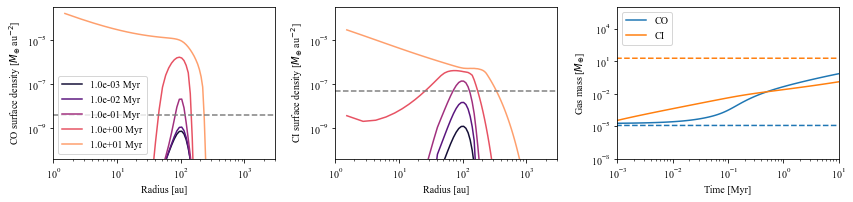

In [7]:
## let's plot now the surface density and mass evolution

# font size and style
font= {'family':'Times New Roman', 'size': 10}
rc('font', **font)

### critical surface densities
sigma_C1c=(1./sigma_c1)*m_c1/Mearth*au_cm**2.0 # mearth/au2
sigma_COc=(1./sigma_co)*m_co/Mearth*au_cm**2.0 # mearth/au2


fig=plt.figure(figsize=(12,3))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
vmin=0.1
vmax=0.8
#### plottingg surface densities
for i, ti in enumerate(ts_plot):
    it=0
    ### find epoch in time grid
    for k in range(len(sim.ts)):
        if sim.ts[k]>=ti:
            it=k
            break

    cmap=plt.get_cmap('magma')
    x=vmin+(vmax-vmin)*i*1./(len(ts_plot)-1)
    colori=cmap(x)

    ax1.plot(sim.grid.rs, sim.Sigma_g[0,:,it], color=colori, label='%1.1e'%(ts_plot[i]/1.0e6)+' Myr')
    ax2.plot(sim.grid.rs, sim.Sigma_g[1,:,it]*fCI, color=colori, label='%1.1e'%(ts_plot[i]/1.0e6)+' Myr')

### draw critical surface densities
ax1.axhline(sigma_COc, color='grey', ls='dashed')
ax2.axhline(sigma_C1c, color='grey', ls='dashed')

# maximum and minimum surface densities to plot
ymax=max( np.max(sim.Sigma_g[0,:,:]), np.max(sim.Sigma_g[1,:,:]), sigma_C1c)*2.0
ymin=min( sim.Sigma_g[0,sim.ibelt,it], sigma_COc)/100.0
for axi in [ax1, ax2]:
    axi.set_xlim(1.0, 3.0e3)
    axi.set_ylim(ymin, ymax)
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.set_xlabel('Radius [au]')
ax1.legend(frameon=True, loc=3)
ax1.set_ylabel(r'CO surface density [$M_{\oplus}$ au$^{-2}$]')
ax2.set_ylabel(r'CI surface density [$M_{\oplus}$ au$^{-2}$]')

#### plotting masses

ax3.plot(sim.ts/1.0e6, MCOs, color='C0', label='CO')
ax3.plot(sim.ts/1.0e6, MCIs*fCI, color='C1', label='CI')

MCO_st=sim.MdotCO*120.0 # solution in quasy steady state if CO is unshielded. Note that sim.dotCO is larger than sim.ts because it is defined over a time grid with the simulation timestep.Its corresponding time array is sim.ts_sim
MCI_st=sim.MdotCO*m_c1/m_co * (2.*sim.rbelt / (3.*sim.nus_au2_yr[0]*(1./sim.grid.rs[0])))*(1.+2.*(rmax_mtot/sim.rbelt)**0.5-1.0) # From integrating Metzeger equations
ax3.plot(sim.ts_sim/1.0e6, MCO_st, color='C0', ls='dashed')
ax3.plot(sim.ts_sim/1.0e6, MCI_st, color='C1', ls='dashed')
ax3.set_ylabel(r'Gas mass [$M_{\oplus}$]')
ax3.set_xlabel(r'Time [Myr]')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(ts_plot[0]/1.0e6, ts_plot[-1]/1.0e6)
ax3.set_ylim(1.0e-8, 1.0e6)
ax3.legend(frameon=True, loc=2)
plt.tight_layout()


We can also use the built in function to plot the results using `sim.plot_panels` that returns a figure

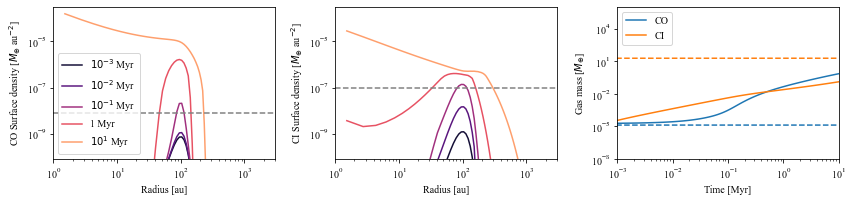

In [8]:
fig=sim.plot_panels(ts_plot)

### exogas by default assumes that CO and CI are unmixed with CI in the surface and CO near the midplane. 

This might not be necessary the case (Marino et al. 2022 submitted). We will now consider a case where CO and CI are perfectly mixed setting the parameter `mixed` to `True`

  0%|          | 388/166666 [00:00<00:42, 3875.65it/s]

fixed CO input rate based on Mdot given by the user
Rmin = 1.0 au
Rmax = 3000.0 au
Nr = 126
Nt simulation=166667
simulation timestep = 60.0 yr
viscous timescale to cross one radial bin = 419278.7 yr
tvis = 5.9e+07 yr
Mdot CO at t=0 is 1.0e-07 Mearth/yr
Mdot CO at t=tf is 1.0e-07 Mearth/yr
Running simulation...


100%|██████████| 166666/166666 [00:41<00:00, 4054.38it/s]


simulation finished
Execution time in sec:  41.0


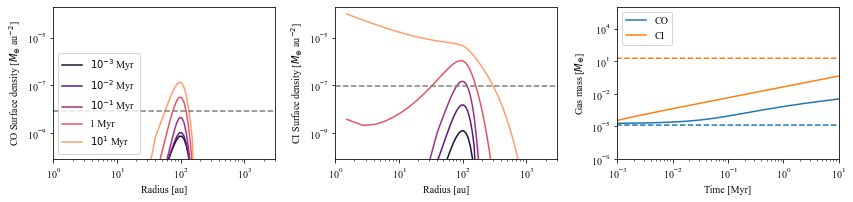

In [9]:
#### INITIALIZE SIMULATION
sim=rsim.simulation(ts_out=ts_out, 
                    Mstar=Mstar,
                    Lstar=Lstar,
                    fco=fco,
                    rbelt=rbelt,
                    width=width,
                    alpha=alpha,
                    MdotCO=MdotCO, # This line is optional depending on if you want to set MdotCO to a specific value or not
                    #fir=fir,
                    fion=fion,
                    tcoll=tcoll,
                    mixed=True
                    )

#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.viscous_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 

fig=sim.plot_panels(ts_plot)

# Customization

You can customize a few things depending on your needs. For example, you can increase the resolution with the parameter resolution, which sets the fractional width of the radial bin at the belt location. So for example, a resolution of 0.1 for a belt at 100 au, will have a radial bin at 100 au with a width of 10 au. By default the resolution is set to 0.1.

You can also change the initial surface density to whatever you want. By default this is set to a power law with an exponential cut-off radius of 50au. 

$$ 10^{-50}  \left(\frac{r}{r_c}\right)^{-1}\exp\left[-\frac{r}{r_c}\right]\ M_{\oplus}\ {\rm au}^{-2}$$

Moreover, you can switch on and off the viscous evolution, CO photodissociation or diffusion with the boolean parameters `viscous`, `photodissociation` and `diffusion`.

In the example below I will change the resolution, increase the viscosity, set `tcoll` to $10^{6}$ yr so the CO input rate will be variable, set the `fir` and omit the CO input rate so the CO input rate will be calculated based on `fir` and `fco`, and define my own initial surface density.


In [10]:
#### INITIALIZE SIMULATION
tcoll=1.0e6 # yr
fir=5.0e-3
sim=rsim.simulation(ts_out=np.logspace(3, np.log10(tf), Ntout), 
                    Mstar=Mstar,
                    Lstar=Lstar,
                    fco=fco,
                    rbelt=rbelt,
                    width=width,
                    alpha=1.0e-1,
                    fir=fir,
                    fion=fion,
                    tcoll=tcoll,
                    resolution=0.05,
                    )
sim.Sigma0[:,:] = 1.0e-10 * (sim.grid.rs/sim.rbelt)**(-1) * np.exp(- sim.grid.rs/sim.rbelt)
#### RUN SIMULATION
print( 'Running simulation...')
T1=time.gmtime()
sim.viscous_evolution()
T2=time.gmtime()
print('Execution time in sec: ',time.mktime(T2)-time.mktime(T1)) 


  0%|          | 251/398660 [00:00<02:38, 2506.34it/s]

varying CO input rate based on final fractional luminosity and tcoll given by the user
Rmin = 1.0 au
Rmax = 5344.7 au
Nr = 312
Nt simulation=398661
simulation timestep = 25.1 yr
viscous timescale to cross one radial bin = 1254.2 yr
tvis = 5.9e+05 yr
Mdot CO at t=0 is 4.9e-05 Mearth/yr
Mdot CO at t=tf is 4.1e-07 Mearth/yr
Running simulation...


100%|██████████| 398660/398660 [02:06<00:00, 3148.00it/s]

simulation finished
Execution time in sec:  126.0


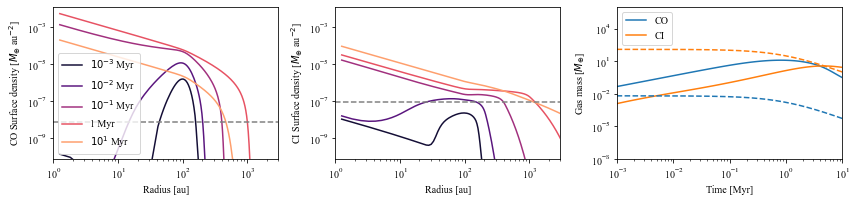

In [11]:
### EPOCHS TO PLOT
ts_plot=np.logspace(3, int(np.log10(tf)), int(np.log10(tf))-3+1) # this will generate epochs from 1000 yr to tf in factors of 10
fig=sim.plot_panels(ts_plot)

You can also include a process to remove carbon based on the amount of dust. This is done by settin the parameter `carbon_capture` to True when you initialize the simulation. You can specify the probability of carbon atoms being captured by grains after a collision with the parameter `pcapture`. The carbon capture surface density rate is set by

$$ \dot{\Sigma}_{\rm C}^{-} = - P_{\rm capture} \frac{\Sigma_{\rm C} \Omega_{\rm K} f_{\rm IR} r}{\sigma_{\rm belt}\sqrt{2\pi}} \exp\left[ - \frac{(r-r_{\rm belt})^2}{2\sigma_{\rm belt}^2} \right] $$ 

This is really something experimental inspired by Cataldi et al. 2020, so please don't take it seriously. 

You can also add the option that the captured carbon forms new CO that is released instantaneously. CO reformation with has a probability `preform` to form a CO molecule for every carbon atom that is captured.